In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [ ]:
mnist = tf.keras.datasets.mnist #28x28 images of handwritten digits of 0-9
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
Y_train.shape

(60000,)

In [ ]:
X_train[0, :]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [ ]:
Y_train[0]

5

In [ ]:
Y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

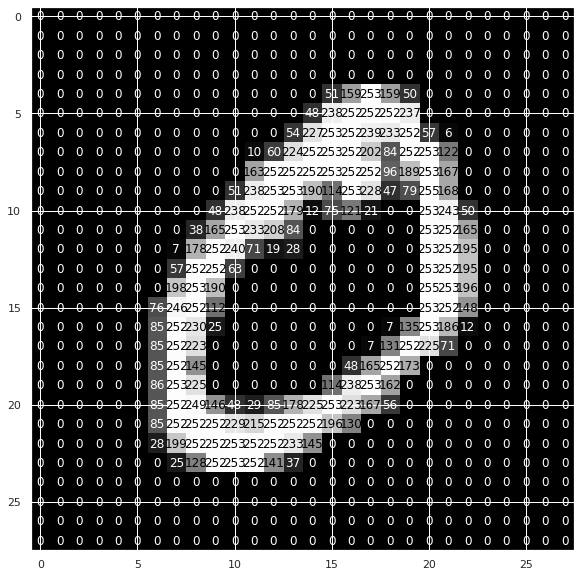

In [ ]:
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input((X_train[1]), ax)

In [ ]:
df = pd.DataFrame(Y_train, columns=['label'])
print(df)

       label
0          5
1          0
2          4
3          1
4          9
...      ...
59995      8
59996      3
59997      5
59998      6
59999      8

[60000 rows x 1 columns]


In [ ]:
df.isnull().sum()

label    0
dtype: int64

In [ ]:
df.nunique()

label    10
dtype: int64

label
0        5923
1        6742
2        5958
3        6131
4        5842
5        5421
6        5918
7        6265
8        5851
9        5949
dtype: int64


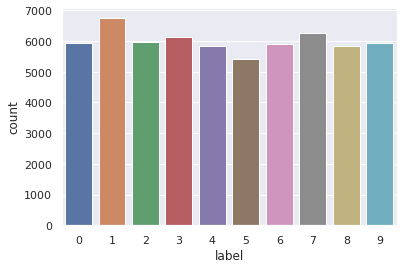

In [ ]:
print(df.value_counts(sort=False))
sns.set_theme(style="darkgrid")
sns.countplot(x='label', data=df)

**Time to build a machine learning model**

In [ ]:
X784_train = X_train.reshape(60000, 784)
X784_test = X_test.reshape(10000, 784)

In [ ]:
def sigmoid(a):
    h = 1/(1 + np.exp(-a))
    return h

def identity(a):
    return a

def softmax(a):
  '''
  a: N x K
  '''
  amax = np.max(a, axis=1, keepdims=True)
  
  ea = np.exp(a - amax)

  s = np.sum(ea, axis=1, keepdims=True)
  z = ea/s
  return z

def mse_loss(x, y, yp):

    return np.mean((yp - y)**2)

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, axis=1)


def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [ ]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) #create a plain empty array
    one_hot_Y[np.arange(Y.size), Y] = 1 #put value of 1 into the array represent the actual value 
    
    return one_hot_Y

In [ ]:
def init_params(n):
    '''
    initialize parameters randomly 
    n is number of Hidden units
    '''
    W1 = np.random.rand(n, 784) - 0.5
    b1 = np.random.rand(n, 1) - 0.5
    W2 = np.random.rand(10, n) - 0.5
    b2 = np.random.rand(10, 1) - 0.5

    return W1, b1, W2, b2

In [ ]:
def cc_entropy(x, yonehot, yp, eps=1e-323, do_sum=True):
    '''
    yonehot: N x K  (in one-hot coding)
    yp: N x K
    '''
    Ln = -np.log(np.sum(yonehot * yp, axis=1, keepdims=True) + eps)

    if do_sum:
      return np.sum(Ln)

    return Ln   

def cross_entropy(x, y, yp):
    
    return np.sum(-np.log(yp[y == 1]))+np.sum(-np.log(1-yp[y == 0]))

In [ ]:
def forwardProp(c, v, b, w, X, oact=identity):

    a = b.T + np.dot(X, w.T)            # a: array N x M
    z = sigmoid(a)                      # z: array N x M

    a2 = c.T + np.dot(z, v.T)           # a2: array N x K
    yhat = oact(a2)                     # yhat: array N x K

    return a, z, a2, yhat

In [ ]:
def backProp(c, v, b, w, X, Y, z, yhat):
      
      delta2 = yhat - Y                   # delta2: array N x K
      OneVec = np.ones(N).reshape((1,-1)) # OneVec: array 1 x N
      dLc = np.dot( OneVec, delta2 ).T    # dLc: array K x 1
      dLv = np.dot( z.T, delta2 ).T       # dLv: array K x M
      H = np.multiply(1 - z, z)           # H: array N x M
      delta1 = np.dot(delta2, v) * H      # delta1: array N x M
      dLb = np.dot( OneVec, delta1 ).T    # dLb: array M x 1
      dLw = np.dot( X.T, delta1 ).T       # dLw: array M x D
      return dLc, dLv, dLb, dLw

In [ ]:
def train_mlp2(c, v, b, w, X, Y, lr1, lr2, nepochs, y,
               oact=identity, loss=mse_loss, disp=False, 
               val=None, val_criteria=1):

  N, D = X.shape

  losses = []

  # For early stopping
  
  best_val_loss = np.inf
  best_params = (c, v, b, w)
  val_count = 0


  # Learning
  for i in range(nepochs+1):
      a, z, a2, yhat = forwardProp(c, v, b, w, X, oact)                   # yhat: array N x K

      dLc, dLv, dLb, dLw = backProp(c, v, b, w, X, Y, z, yhat)

      lossi = loss(X, Y, yhat)
      
      if np.isnan(lossi):  
          print('Reach NaN. Terminated.')
          break

      losses.append(lossi)

      c -= dLc * lr2
      v -= dLv * lr2
      b -= dLb * lr1
      w -= dLw * lr1

      if disp:
        if i % 50 == 0:
            predicted = get_predictions(yhat)
            score = get_accuracy(predicted, y)
            print('i = ', i)
            print('score =', score)

      if val is not None:
        # Do early stopping
        # Here, we use a simple strategy: no best saving and one worse out.

        # (1) Check validate set
        valx, valy = val
        _, _, _, valyp = forwardProp(c, v, b, w, valx, oact)

        val_loss = loss(valx, valy, valyp)
        if i % 50 == 0:
          print(i, '* val loss=', val_loss)
          print()

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_params = (c, v, b, w)
          val_count = 0

        elif val_loss > best_val_loss:
          val_count += 1

          if val_count >= val_criteria:
            print('Early stopping criteria is met at', i)
            c, v, b, w = best_params
            break
          # enf if val_criteria
        # enf if val_loss
      # end if val
      
  # end for i

  return c, v, b, w, losses

In [ ]:
asd=[7284, 7600, 7411, 7114]

[3 0 4 ... 4 0 3] [5 0 4 ... 5 6 8]
i =  0
score = 0.08443333333333333
0 * val loss= 22175.26239179751

[3 0 4 ... 5 0 8] [5 0 4 ... 5 6 8]
i =  50
score = 0.8653666666666666
50 * val loss= 4799.418001894067

[3 0 4 ... 5 0 8] [5 0 4 ... 5 6 8]
i =  100
score = 0.8973166666666667
100 * val loss= 3596.7572261427085

Time spent: 53.11527395248413


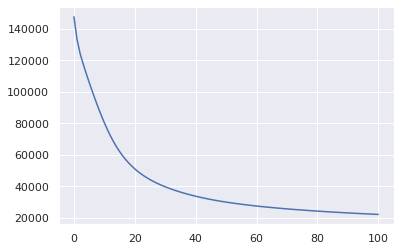

In [ ]:
N, D = X784_train.shape
K = Y_train.shape

n = 20 # number of HU

w, b, v, c = init_params(n) #randomly generate params


#w = np.zeros((n, 784))
#b = np.zeros((n, 1))
#v = np.zeros((10, n))
#c = np.zeros((10, 1))

lr1 = 2.5/N
lr2 = 2.5/N

epochs = 100

X1_train = X784_train/255 #normalize input data
X1_test = X784_test/255 
Y_train_1hot = one_hot(Y_train) # one-hot the output data K x 10, 10 is 10 possible output (0-9)
Y_test_1hot = one_hot(Y_test)

t1 = time.time()

cc, vv, bb, ww, train_loss = train_mlp2(c, v, b, w, X1_train, Y_train_1hot, lr1, lr2, epochs, Y_train, 
                                        softmax, cc_entropy, disp=True, val=(X1_test, Y_test_1hot))
asd.append(val_loss)

plt.plot(train_loss)

t2 = time.time()

print('Time spent:', t2 - t1)

In [ ]:
print(asd)

[7284, 7600, 7411, 7114, 7826.957987118101, 7757.441747806723, 7503.977514787135]


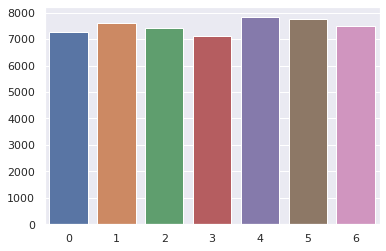

In [ ]:
sns.barplot(x=np.arange(0,7), y=asd )

In [ ]:
print('c', cc)
print('v', vv)
print('b', bb)
print('w', ww)

c [[-0.55049025]
 [-0.59492711]
 [-0.40259522]
 [-0.23632159]
 [-0.02622723]
 [ 0.01010665]
 [-1.04175792]
 [ 0.87682151]
 [ 0.10091449]
 [ 0.10267477]]
v [[-0.68839047 -0.52927517  0.39031269 -1.4518662   1.57789384  0.44178165
   0.28500718 -1.64185177 -0.61353176  2.0992388 ]
 [ 1.17259123  1.14379603  1.59034665  0.1267585  -1.38854638  0.55936702
  -1.50984049  1.40050752 -1.00889516 -1.23003989]
 [-1.18807405  1.1296303   1.89568136  0.46896279  0.34804633 -1.63167985
   0.07570423  0.82893349 -0.04374619 -0.30262807]
 [-0.41019922  1.80216468 -1.37072708 -1.153277    1.20498418  0.2755635
  -0.02728393  0.93309915 -0.83726285 -0.26297958]
 [ 1.26248676 -0.67251403 -1.00417748  1.69597545  0.64927684 -0.058011
  -0.18940248 -0.93490277  0.63263645 -1.12252204]
 [ 0.15297524 -0.74803476 -0.77117582 -1.32567044  0.65793691  0.97697626
  -0.06218333  0.66311137 -0.63731218  1.24363856]
 [-0.80575021 -0.61474485  0.97291814  1.79764139  0.10223527  0.50122942
  -0.39646651  0.4152717

In [ ]:
Y_train_1hot.shape

(60000, 10)

In [ ]:
_, _, _, Yp = forwardProp(cc ,vv, bb, ww, X1_test, softmax)
pred = get_predictions(Yp)

In [ ]:
accuracy_score = np.mean(pred == Y_test.astype(np.int))
print('model testing accuracy:', accuracy_score)

model testing accuracy: 0.902


(10, 1)
(10, 20)
(20, 1)
(20, 784)


Text(0.5, 1.0, 'w (weights 1)')

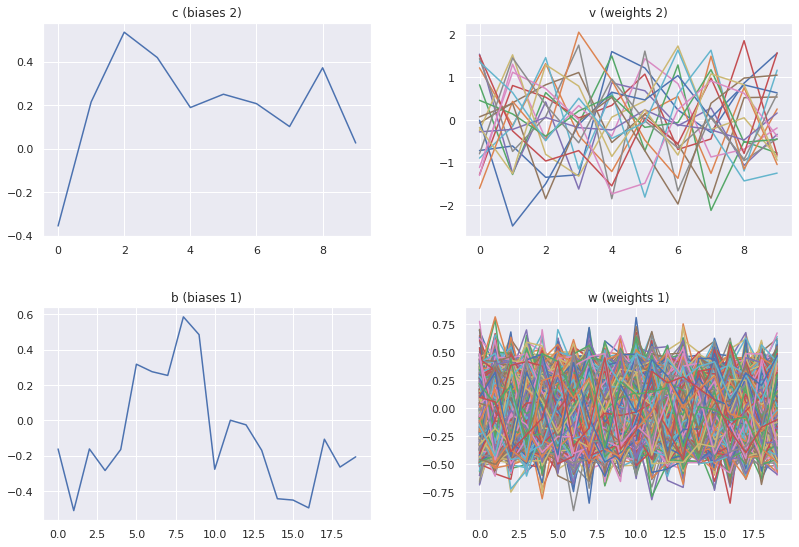

In [ ]:
print(cc.shape)
print(vv.shape)
print(bb.shape)
print(ww.shape)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout(rect=[0.1, 0.1, 2, 2], h_pad=4, w_pad=4)

plt.subplot(2,2,1)
plt.plot(cc)
plt.title('c (biases 2)')

plt.subplot(2,2,2)
plt.plot(vv)
plt.title('v (weights 2)')

plt.subplot(2,2,3)
plt.plot(bb)
plt.title('b (biases 1)')

plt.subplot(2,2,4)
plt.plot(ww)
plt.title('w (weights 1)')

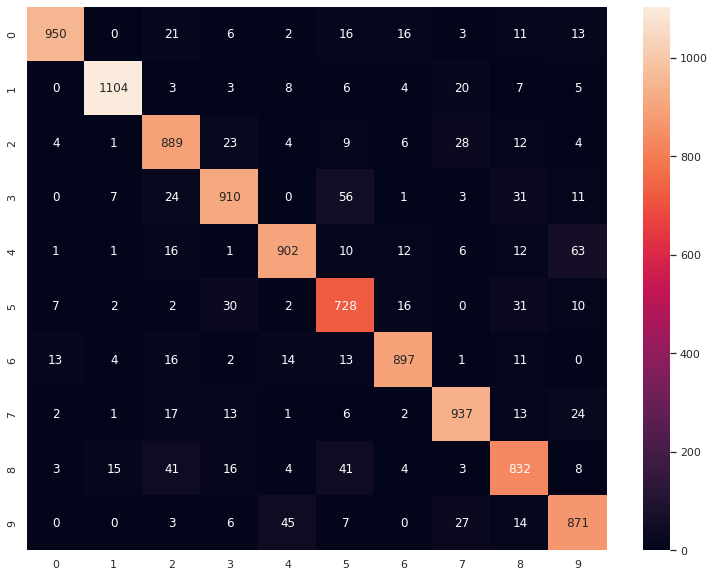

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(pred, Y_test)

fig = plt.figure(figsize=(13,10))
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [ ]:
df_test = pd.DataFrame(Y_test, columns=['label'])
dfvc = df_test.value_counts(sort=False)
print(dfvc)

label
0         980
1        1135
2        1032
3        1010
4         982
5         892
6         958
7        1028
8         974
9        1009
dtype: int64


In [ ]:
diffdict = {}
for i in range(10):
  diff = int(dfvc[i]) - int(cf_matrix[i][i])
  diffdict[i] = diff
diffS = pd.Series(data=diffdict, index=np.arange(0,10)
        , name='label')
print(diffS)

0     30
1     31
2    143
3    100
4     80
5    164
6     61
7     91
8    142
9    138
Name: label, dtype: int64


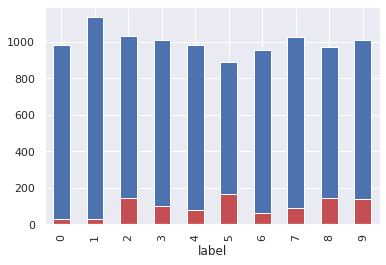

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)

dfvc.plot.bar()
diffS.plot.bar(color='r')